# 基于施密特分解的分布式变分量子本征求解器

*Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved.*

## 概览

在物理和化学等学科中，一个非常重要的问题就是提取分子、原子等物理系统的基态信息。系统的基态是由系统对应的哈密顿量决定的。目前普遍认为量子计算机在求解哈密顿量基态问题上具有优势。[变分量子本征求解器](https://qml.baidu.com/tutorials/quantum-simulation/variational-quantum-eigensolver.html)（variational quantum eigensolver, VQE），作为有望在近期展现量子优势的算法之一，为研究者们提供了可以在含噪的中等规模量子（NISQ）设备上研究量子化学的可能。然而，目前 NISQ 设备仍存在许多局限性，阻碍了大规模量子算法的运行。例如，受限于现有量子设备所能提供的量子比特数，研究者们无法利用 VQE 在 NISQ 设备上模拟真实的大分子。为了突破这一限制，许多分布式方案 [1-3] 相继被提出。
在本教程中，我们以 [4] 提出的基于施密特分解的 VQE 为例，向读者展示如何利用 Paddle Quantum 实现分布式量子算法。

## 施密特分解

对于任意处于复合系统 $AB$ 上的纯态 $|\psi\rangle$，我们有如下平凡分解:

$$
|\psi\rangle=\sum_{ij}a_{ij}|i\rangle\otimes|j\rangle,
\tag{1}
$$

其中 $|i\rangle$ 和 $|j\rangle$ 分别是子系统 $A$、$B$ 上的计算基底，$a_{ij}$ 是某复矩阵 $a$ 的元素。接下来，我们对矩阵 $a$ 运用[奇异值分解](https://zh.wikipedia.org/wiki/奇异值分解)（singular value decomposition, SVD），即，$a = udv$，其中 $u,v$ 是酉矩阵，$d$ 是对角矩阵。那么，$a_{ij}=\sum_ku_{ik}d_{kk}v_{kj}$。

通过定义 

$$
\begin{aligned}
|k_A\rangle\equiv & \sum_iu_{ik}|i\rangle=u|k\rangle,\\
|k_B\rangle\equiv & \sum_jv_{kj}|j\rangle=v^T|k\rangle,\\
\lambda_k\equiv & d_{kk},\end{aligned}
\tag{2}
$$

我们可以把（1）式重写为

$$
\begin{aligned}
    |\psi\rangle  &= \sum_{ijk}u_{ik}d_{kk}v_{kj}|i\rangle\otimes|j\rangle \\
                &= \sum_{k}\lambda_{k}\Big(\sum_iu_{ik}|i\rangle\Big)\otimes\Big(\sum_jv_{kj}|j\rangle\Big) \\
                &=\sum_{k}\lambda_k(u|k\rangle\otimes v^T|k\rangle)\\
                &=\sum_{k}\lambda_k|k_A\rangle\otimes|k_B\rangle.
\end{aligned}
\tag{3}
$$

形如 $|\psi\rangle=\sum_k\lambda_k|k_A\rangle\otimes|k_B\rangle$ 的分解方式就称为 **施密特分解**  [5]。同时，$\{\lambda_k\}_k$ 被称作施密特系数，非零 $\lambda_k$ 的数量被称为 $|\psi\rangle$ 的施密特秩。事实上，奇异值分解的性质还保证了 $\lambda_k\in\mathbb{R}^+$ 及 $\sum_k\lambda_k^2=1$。

## 基于施密特分解的分布式 VQE

作为标准 VQE [6] 的一个变种，分布式 VQE 同样试图寻找一个 $N$ 量子比特哈密顿量 $\hat{H}=\sum_tc_t\hat{H}_t^{(A)}\otimes\hat{H}_t^{(B)}$ 的基态及其能量，其中 $\hat{H}_t^{(A)},\hat{H}_t^{(B)}$ 是分别作用于子系统 $A$、$B$ 上的哈密顿量分量（我们假设 $A$、$B$ 都包含 $N/2$ 量子比特）。

我们从如下试探波函数开始：

$$
|\psi\rangle\equiv\sum_{k=1}^S\lambda_k\Big(U(\boldsymbol{\theta})|k\rangle\Big)\otimes\Big(V(\boldsymbol{\phi})|k\rangle\Big)
\tag{4},
$$

其中 $\boldsymbol{\lambda}\equiv(\lambda_1, \lambda_2,...,\lambda_S)^T$，$1\leq S\leq 2^{N/2}$ 是一个用户定义的常数。根据施密特分解，目标基态同样可写成（4）式的形式。因此，通过寻找合适的参数向量 $\boldsymbol{\lambda}, \boldsymbol{\theta}$ 和 $\boldsymbol{\phi}$，我们可以在任意误差内近似目标基态。

接下来，对于所有 $i,j=1,...,S$，我们在一台 $N/2$ 量子比特的量子计算机上计算如下项：

$$
\begin{aligned}
E_{ijt}^A(\boldsymbol{\theta}) &\equiv \langle i|U^\dagger(\boldsymbol{\theta}) \hat{H}_t^{(A)} U(\boldsymbol{\theta})|j\rangle,\\
E_{ijt}^B(\boldsymbol{\phi}) &\equiv \langle i|V^\dagger(\boldsymbol{\phi}) \hat{H}_t^{(B)} V(\boldsymbol{\phi}))|j\rangle.
\end{aligned}
\tag{5}
$$

然后，在一台经典计算机上，我们根据如下定义构造一个 $S\times S$ 维的矩阵 $M(\boldsymbol{\theta},\boldsymbol{\phi})$：

$$
[M(\boldsymbol{\theta},\boldsymbol{\phi})]_{ij}\equiv\sum_tc_tE_{ijt}^A(\boldsymbol{\theta})E_{ijt}^B(\boldsymbol{\phi}).
\tag{6}
$$

这样，目标基态能量就可以写为 

$$
\begin{aligned}
E_{tar}   &= \min_{\boldsymbol{\lambda}, \boldsymbol{\theta}, \boldsymbol{\phi}} \langle{\psi}|\hat{H}|\psi\rangle \\
    &= \min_{\boldsymbol{\lambda}, \boldsymbol{\theta}, \boldsymbol{\phi}}\Big(\sum_{i,j=1}^S\lambda_i\lambda_j[M(\boldsymbol{\theta},\boldsymbol{\phi})]_{ij}\Big)\\
    &= \min_{\boldsymbol{\theta}, \boldsymbol{\phi}} E(\boldsymbol{\theta},\boldsymbol{\phi}),
\end{aligned}
\tag{7}
$$

其中 $E(\boldsymbol{\theta},\boldsymbol{\phi})\equiv\min_{\boldsymbol{\lambda}} \boldsymbol{\lambda}^T M(\boldsymbol{\theta},\boldsymbol{\phi})\boldsymbol{\lambda}$。根据线性代数的内容，不难发现，$E(\boldsymbol{\theta},\boldsymbol{\phi})$ 正是矩阵 $M(\boldsymbol{\theta},\boldsymbol{\phi})$ 的最小特征值，可以通过经典算法求得。

最终，我们重复如上过程，并使用基于梯度下降的优化方法最小化 $E(\boldsymbol{\theta},\boldsymbol{\phi})$，使其趋近于 $E_{tar}$。




## 量桨实现

首先，我们导入必要的包。由于我们要使用飞桨和量桨的最新功能，请确保您的 *PaddlePaddle* >= 2.2.0 且 *Paddle Quantum* >= 2.1.3。

In [1]:
import time
import numpy as np
from matplotlib import pyplot as plt

import paddle
from paddle_quantum.circuit import UAnsatz
from paddle_quantum.utils import pauli_str_to_matrix, schmidt_decompose

定义一些全局常数：

In [2]:
N = 10      # 量子比特数
SEED = 16   # 固定随机种子
ITR = 100   # 设置迭代次数
LR = 0.1    # 设置学习率
D = 3       # 设置量子神经网络的层数

下面这一函数经典地计算出哈密顿量 $H$ 的基态信息（基态对能量和施密特秩），以作为后面量子模型的基准参照。

In [3]:
def get_ground_state_info(H):

    # 计算 H 的特征值与特征向量
    vals, vecs = paddle.linalg.eigh(H)
    # 获取基态
    ground_state = vecs[:, 0].numpy()
    # 获取基态能量
    ground_state_energy = vals.tolist()[0]
    print(f'The ground state energy is {ground_state_energy:.5f} Ha.')
    # 对基态运用施密特分解
    l, _, _ = schmidt_decompose(ground_state)
    print(f'Schmidt rank of the ground state is {l.size}.')

    return ground_state_energy

现在，我们生成一个哈密顿量并计算其基态信息。

In [4]:
# 固定随机种子
np.random.seed(SEED)

# 硬编码一个哈密顿量
coefs = [-0.8886258, 0.453882]
pauli_str = ['x0,z1,z2,z4,x5,y6,y7,x8,x9', 'y0,x1,x2,x3,y4,x5,z6,z7,y8,x9']
pauli_str_A = ['x0,z1,z2,z4', 'y0,x1,x2,x3,y4']     # 子系统 A 的泡利字符串
pauli_str_B = ['x0,y1,y2,x3,x4', 'x0,z1,z2,y3,x4']  # 子系统 B 的泡利字符串

# 把相关对象转换为张量形式
H_mtr = paddle.to_tensor(pauli_str_to_matrix(zip(coefs, pauli_str), n=N))
coefs = paddle.to_tensor(coefs)
H_A = [pauli_str_to_matrix([[1., pstr]], n=N//2) for pstr in pauli_str_A]
H_A = paddle.to_tensor(np.stack(H_A))
H_B = [pauli_str_to_matrix([[1., pstr]], n=N-N//2) for pstr in pauli_str_B]
H_B = paddle.to_tensor(np.stack(H_B))

# 计算该哈密顿量的基态信息
ground_state_energy = get_ground_state_info(H_mtr)

The ground state energy is -0.99783 Ha.
Schmidt rank of the ground state is 3.


准备好一个哈密顿量后，我们可以构建一个分布式 VQE 来求解它。

In [5]:
# 构造参数化量子电路
def U_theta(param, N, D):
    
    cir = UAnsatz(N)  # 初始化一个宽度为 N 量子比特的电路
    cir.complex_entangled_layer(param, D)  # 添加量子门
    return cir.U  # 获取参数化电路的矩阵

# 把参数化电路作用在计算基底上
# 并返回一个形状为 [2**N, num_states] 的张量
def output_states(theta, num_states, N, D):
    # 创建 num_states 个计算基底
    basis = paddle.eye(2**N, num_states)
    
    # 获得参数化电路
    U = U_theta(theta, N, D)
    
    # 把参数化电路作用在这些基底上
    vec = U @ basis                         
    
    return vec

以下代码是本教程的核心。请读者仔细阅读，并与前文的公式叙述做比较。

In [6]:
# 构造分布式模型
class DistributedVQE(paddle.nn.Layer):
    def __init__(self, N, D, S):
        super().__init__()
        paddle.seed(SEED)

        # 定义常数 S
        self.S = S
        self.N, self.D = N, D
        # 初始化参数列表 theta, phi，并用 [0, 2*pi] 的均匀分布来填充初始值
        self.theta = self.create_parameter(shape=[D, N//2, 3], dtype="float64",
                                default_initializer=paddle.nn.initializer.Uniform(low=0.0, high=2*np.pi))
        self.phi = self.create_parameter(shape=[D, N - N//2, 3], dtype="float64",
                                default_initializer=paddle.nn.initializer.Uniform(low=0.0, high=2*np.pi))
        
    # 分布式 VQE 的核心逻辑
    def forward(self):
        # 分别获得子系统 A、B 上的 U|k> 和 V|k> 
        vec_A = output_states(self.theta, self.S, self.N//2, self.D)
        vec_B = output_states(self.phi, self.S, self.N - self.N//2, self.D)
        
        # 计算由前文定义的 E_{ijt}^A 和 E_{ijt}^B 组成的张量 E_A, E_B
        E_A = vec_A.conj().t() @ H_A @ vec_A
        E_B = vec_B.conj().t() @ H_B @ vec_B
        M = (coefs.reshape([-1, 1, 1]) * E_A * E_B).sum(0)

        # 计算矩阵 M 的最小特征值
        eigval = paddle.linalg.eigvalsh(M)
        loss = eigval[0]
        
        return loss

定义训练函数。

In [7]:
def train(model):
    start_time = time.time()    # 用以计算该函数的运行时长
    
    # 我们使用基于梯度下降的优化器 Adam 来优化 theta 和 phi
    opt = paddle.optimizer.Adam(learning_rate=LR, parameters=model.parameters())
    summary_loss = []           # 记录损失历史

    # 迭代优化
    for itr in range(ITR):

        # 前向传播，计算损失函数
        loss = model()

        # 后向传播，优化损失函数
        loss.backward()
        opt.minimize(loss)
        opt.clear_grad()

        # 更新优化结果
        summary_loss.append(loss.numpy())

        # 打印中间结果
        if (itr+1) % 20 == 0:
            print(f"iter: {itr+1}, loss: {loss.tolist()[0]: .4f} Ha")

    print(f'Ground truth is  {ground_state_energy:.4f} Ha')
    print(f'Training took {time.time() - start_time:.2f}s')
    
    plt.plot(list(range(ITR)), summary_loss, color='r', label='loss')
    plt.hlines(y=ground_state_energy, xmin=0, xmax=ITR, linestyle=':',  label='ground truth')
    plt.legend()
    plt.title(f'Loss for {type(model).__name__} on a {N}-qubit Hamiltonian')
    plt.show()

现在，我们实例化并训练分布式模型。

iter: 20, loss: -0.9244 Ha
iter: 40, loss: -0.9906 Ha
iter: 60, loss: -0.9968 Ha
iter: 80, loss: -0.9977 Ha
iter: 100, loss: -0.9978 Ha
Ground truth is  -0.9978 Ha
Training took 13.01s


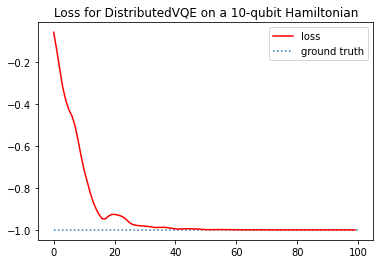

In [ ]:
# 注意，由于我们构造的哈密顿量在两子系统间相互作用较小，我们只需设置 S = 4.
#（更多解释请见总结部分）
vqe = DistributedVQE(N, D, S=4)
train(vqe)

在上图中，我们用虚线画出了真实的基态能量。可以看到，loss 曲线收敛至虚线，表明我们的分布式 VQE 成功找到了该哈密顿量的基态能量。然而，要妥当地评估我们的模型，我们还需将它与标准 VQE 做比较。因此，下面我们构建标准 VQE 模型：

In [9]:
class StandardVQE(paddle.nn.Layer):
    def __init__(self, N, D):
        super().__init__()
        paddle.seed(SEED)
        self.N, self.D = N, D
        self.theta = self.create_parameter(shape=[D, N, 3], dtype="float64",
                                default_initializer=paddle.nn.initializer.Uniform(low=0.0, high=2*np.pi))
        
    def forward(self):
        vec = output_states(self.theta, 1, self.N, self.D)
        loss = vec.conj().t() @ H_mtr @ vec
        return loss.cast('float64').flatten()

实例化并训练标准 VQE。

iter: 20, loss: -0.8365 Ha
iter: 40, loss: -0.9852 Ha
iter: 60, loss: -0.9958 Ha
iter: 80, loss: -0.9975 Ha
iter: 100, loss: -0.9978 Ha
Ground truth is  -0.9978 Ha
Training took 721.76s


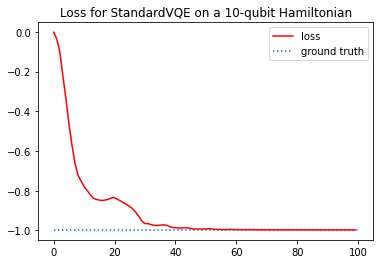

In [10]:
svqe = StandardVQE(N, D)
train(svqe)  # 训练标准 VQE

有趣的是，通过比较两个模型的运行时间，我们发现，分布式 VQE 的运行速度比标准 VQE 快了五十多倍！事实上，这很容易理解：在分布式模型中，我们只需模拟两个 $N/2$ 量子比特的酉变换，这无论在时间还是空间上，都比标准 VQE 中模拟一个 $N$ 量子比特的酉变换高效得多。

## 总结

在此教程中，我们构造了一个分布式 VQE 并展示了其部分优势：
- NISQ 设备的计算范围得以拓展。通过分布式策略，我们可以运行超过硬件量子比特数的量子算法。
- 计算效率得到提升。对于量子过程的经典模拟而言，分布式算法降低了酉矩阵的维度，因此降低了模拟这些矩阵所需的时间、空间消耗。

同时，需要注意的是，用户定义的常数 $S$ 在训练准确度和效率上扮演了重要角色：
- 对于子系统间相互作用弱的哈密顿量而言，其基态在子系统间纠缠较弱 [7]。因此，其施密特秩较低，可以被一个较小的 $S$ 精确且高效地模拟。事实上，我们所给的演示及大多数物理、化学中有意义的哈密顿量都具有此性质。
- 相反的，对于子系统间相互作用强的哈密顿量而言，其基态在子系统间纠缠较强，因此需要一个较大的 $S$ 来模拟。但是，无论如何，$S$ 的上界是 $2^{N/2}$，因此矩阵 $M$ 的维度上界是 $2^{N/2}\times2^{N/2}$，这仍然比初始哈密顿量的维度（$2^{N}\times 2^{N}$）小。因此，该算法的效率总是优于纯经典模拟。

_______

# 参考文献

[1] Fujii, Keisuke, et al. "Deep Variational Quantum Eigensolver: a divide-and-conquer method for solving a larger problem with smaller size quantum computers." [arXiv preprint arXiv:2007.10917 (2020)](https://arxiv.org/abs/2007.10917).

[2] Zhang, Yu, et al. "Variational Quantum Eigensolver with Reduced Circuit Complexity." [arXiv preprint arXiv:2106.07619 (2021)](https://arxiv.org/abs/2106.07619).

[3] Peng, Tianyi et al. "Simulating Large Quantum Circuits On A Small Quantum Computer". [Physical Review Letters 125.15, (2020): 150504](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.125.150504).

[4] Eddins, Andrew, et al. "Doubling the size of quantum simulators by entanglement forging." [arXiv preprint arXiv:2104.10220 (2021)](https://arxiv.org/abs/2104.10220).

[5] Nielsen, Michael A., and Isaac L. Chuang. Quantum Computation and Quantum Information. Cambridge University Press, 2010.

[6] Moll, Nikolaj, et al. "Quantum optimization using variational algorithms on near-term quantum devices." [Quantum Science and Technology 3.3 (2018): 030503](https://iopscience.iop.org/article/10.1088/2058-9565/aab822).

[7] Khatri, Sumeet, and Mark M. Wilde. "Principles of quantum communication theory: A modern approach." [arXiv preprint arXiv:2011.04672 (2020)](https://arxiv.org/abs/2011.04672).